# Project D4: Predicting LoL winner

Team members - Veronika Kukk, Robin Piir, Otto Kase
<br>Github - https://github.com/VeronikaKukk/DS_project 

# Gathering data

Data was gathered from Riot API by using development API key.\
Code for that is written in request_info.py.\
\
First we took a look at what kind of game data does Riot store and how does it do it. To get any information, it is required to have a API key for requesting data. We used a development API key that anyone with a riotgames account can have. For the attributes we used the same ones as a Kaggle dataset (https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min). We did not use the Kaggle dataset itself because it is from atleast 3 years ago. We collected information from Europe servers (EUNE and EUW).
\
\
In the request_info.py we have 6 methods. First we had to find summonerId-s (player ids) that belong to ranked solo Diamond I players. For that we looked at first 4 pages of ranked solo Diamond I players. Then we used the summonerId to find summoner_puuids belonging to those players. After that we took the summoner_puuids and found their 20 most recent ranked games. For each game we requested the game timeline to gather the information from first 10 minutes (everything up to the 10 minutes mark). This method already excluded games that had missing values (None) and were less than 10 minutes. 
\
\
Since there is a limit on how many request can be made in a minute, we had to let the program wait between every request. It was our first time gathering data by requesting it, so to make fewer mistakes, we wrote every method outcome to a separate file incase it needs to be reused. This means that for example if the API key expires while requesting data, we do not have to start over, we can continue from last saved file.
\
This gathering method has already removed any games that were less than 10 minutes and has only taken ranked games from players with rank Diamond I in ranked solo. 

# Importing libraries

In [1]:
# Everything that needs to be imported (libraries)
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
import numpy as np
from sklearn import preprocessing

# Model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB

# Evaluation
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Combining data

To analyze servers we first need to combine files from those servers into one. This means that all of EUNE data will be in one dataframe and all of EUW data will be in one dataframe.

In [2]:
# import all eune files to dataframes
df_eune1 = pd.read_csv("eune_data1.csv", index_col=0)
df_eune2 = pd.read_csv("eune_data2.csv", index_col=0)
df_eune3 = pd.read_csv("eune_data3.csv", index_col=0)
df_eune4 = pd.read_csv("eune_data4.csv", index_col=0)

In [3]:
# import all euw files to dataframes
df_euw1 = pd.read_csv("euw_data1.csv", index_col=0)
df_euw2 = pd.read_csv("euw_data2.csv", index_col=0)
df_euw3 = pd.read_csv("euw_data3.csv", index_col=0)
df_euw4 = pd.read_csv("euw_data4.csv", index_col=0)

In [4]:
df_eune1

,matchId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,...,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,bluewins
0,EUN1_3250387583,118,4,1,4,3,5,0,0,0,...,14267,7.0,16956,193,72,8,-2314,21.436862,1584.661722,0
1,EUN1_3250345989,15,2,0,7,3,5,0,0,0,...,13815,6.4,15507,183,48,1397,893,20.325918,1534.440213,1
2,EUN1_3250132600,13,0,0,3,2,3,0,0,0,...,14202,7.0,17682,205,48,-544,-1343,22.768502,1577.357373,0
3,EUN1_3250109344,10,1,1,3,3,0,0,0,0,...,14684,6.6,16566,194,60,-541,111,21.549689,1631.111531,1
4,EUN1_3250074417,12,0,0,0,4,0,0,0,0,...,14784,6.6,16370,203,50,-2446,-2208,22.544534,1641.863978,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4063,EUN1_3241781223,112,1,1,12,4,10,1,0,1,...,14534,6.4,15108,175,52,3242,2265,19.439261,1614.458367,1
4064,EUN1_3241746052,17,5,1,13,6,20,0,0,0,...,15496,6.4,16230,195,64,3805,1745,21.659246,1721.188111,1
4065,EUN1_3241710887,16,1,0,3,9,3,0,0,0,...,17167,6.6,16519,171,56,-3654,-1748,18.995111,1906.953580,1
4066,EUN1_3241682864,34,1,0,4,7,2,0,0,0,...,14538,6.4,14915,171,36,568,1714,18.995181,1614.923621,0


In [5]:
# combining all of the dataframes of both servers into one
eune_dfs = [df_eune1, df_eune2, df_eune3, df_eune4]
euw_dfs = [df_euw1, df_euw2, df_euw3, df_euw4]

df_eune = pd.concat(eune_dfs, ignore_index=True)
df_euw = pd.concat(euw_dfs, ignore_index=True)

In [6]:
df_eune

,matchId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,...,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,bluewins
0,EUN1_3250387583,118,4,1,4,3,5,0,0,0,...,14267,7.0,16956,193,72,8,-2314,21.436862,1584.661722,0
1,EUN1_3250345989,15,2,0,7,3,5,0,0,0,...,13815,6.4,15507,183,48,1397,893,20.325918,1534.440213,1
2,EUN1_3250132600,13,0,0,3,2,3,0,0,0,...,14202,7.0,17682,205,48,-544,-1343,22.768502,1577.357373,0
3,EUN1_3250109344,10,1,1,3,3,0,0,0,0,...,14684,6.6,16566,194,60,-541,111,21.549689,1631.111531,1
4,EUN1_3250074417,12,0,0,0,4,0,0,0,0,...,14784,6.6,16370,203,50,-2446,-2208,22.544534,1641.863978,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16246,EUN1_3245368080,75,4,1,6,6,8,0,0,0,...,15542,6.6,16303,194,56,-509,-1744,21.549649,1726.415723,1
16247,EUN1_3245264423,9,3,0,1,6,1,0,0,0,...,14910,6.4,16199,185,40,-1725,-1144,20.548097,1656.065576,0
16248,EUN1_3245007949,14,0,0,4,7,5,0,0,0,...,14705,6.6,16327,164,56,-501,-496,18.216353,1633.362583,1
16249,EUN1_3244978461,11,1,0,0,9,0,0,0,0,...,15390,6.2,15396,169,44,-2950,-967,18.771764,1709.452342,0


In [7]:
df_euw

,matchId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,...,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,bluewins
0,EUW1_6141576712,13,0,0,2,8,1,0,0,0,...,17711,6.8,17142,231,50,-4725,-2951,25.657544,1967.189444,0
1,EUW1_6141532322,11,1,0,10,13,12,0,0,0,...,18593,6.4,16496,168,52,-788,127,18.661725,2065.341956,0
2,EUW1_6141500534,11,2,1,8,8,9,1,0,1,...,15676,6.2,15514,162,40,648,-1210,17.994502,1741.245730,1
3,EUW1_6141433343,16,4,0,8,7,7,0,0,0,...,15287,6.2,15702,198,36,1181,1308,21.994461,1698.127879,0
4,EUW1_6141410859,12,6,1,4,8,2,0,0,0,...,17163,6.8,17342,218,52,-2724,-1242,24.216930,1906.583376,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15978,EUW1_6066115292,13,4,1,11,6,10,0,0,0,...,14745,6.2,14569,137,40,3023,1524,15.217037,1637.775277,0
15979,EUW1_6064645200,16,0,1,20,6,14,0,0,0,...,14590,5.8,14197,141,43,6159,4105,15.662519,1620.681931,1
15980,EUW1_6064572344,11,1,0,7,9,10,0,0,0,...,15766,6.6,16694,199,48,1619,-109,22.106199,1751.388580,1
15981,EUW1_6064260946,12,1,0,5,7,6,0,0,0,...,15865,6.6,16212,195,53,-1194,-2290,21.659206,1762.170808,0


Before moving on to the next step, we decided to change the last columns name. Before it was called "bluewins" but for it to have the same style as the other columns, we changed it to "blueWins".

In [8]:
# changing the name of a column
df_eune.rename(columns={'bluewins': 'blueWins'}, inplace=True)
df_euw.rename(columns={'bluewins': 'blueWins'}, inplace=True)

In [9]:
df_eune

,matchId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,...,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
0,EUN1_3250387583,118,4,1,4,3,5,0,0,0,...,14267,7.0,16956,193,72,8,-2314,21.436862,1584.661722,0
1,EUN1_3250345989,15,2,0,7,3,5,0,0,0,...,13815,6.4,15507,183,48,1397,893,20.325918,1534.440213,1
2,EUN1_3250132600,13,0,0,3,2,3,0,0,0,...,14202,7.0,17682,205,48,-544,-1343,22.768502,1577.357373,0
3,EUN1_3250109344,10,1,1,3,3,0,0,0,0,...,14684,6.6,16566,194,60,-541,111,21.549689,1631.111531,1
4,EUN1_3250074417,12,0,0,0,4,0,0,0,0,...,14784,6.6,16370,203,50,-2446,-2208,22.544534,1641.863978,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16246,EUN1_3245368080,75,4,1,6,6,8,0,0,0,...,15542,6.6,16303,194,56,-509,-1744,21.549649,1726.415723,1
16247,EUN1_3245264423,9,3,0,1,6,1,0,0,0,...,14910,6.4,16199,185,40,-1725,-1144,20.548097,1656.065576,0
16248,EUN1_3245007949,14,0,0,4,7,5,0,0,0,...,14705,6.6,16327,164,56,-501,-496,18.216353,1633.362583,1
16249,EUN1_3244978461,11,1,0,0,9,0,0,0,0,...,15390,6.2,15396,169,44,-2950,-967,18.771764,1709.452342,0


# Cleaning data

In [10]:
# Find whether any games have no values
eune_nan = df_eune.isna().any(axis=1).sum()
euw_nan = df_euw.isna().any(axis=1).sum()
print("Number of missing values in EUNE: "+str(eune_nan))
print("Number of missing values in EUW: "+str(euw_nan))

Number of missing values in EUNE: 0
Number of missing values in EUW: 0


This means that there are no rows with missing values. No need to remove any rows because of this.

### Inspecting the mean, min and max

In [11]:
# Since we want to see all columns, we set the max_columns to None
pd.set_option('display.max_columns', None)
df_eune.describe()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redEliteMonsters,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
count,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000,16251.000000
mean,18.836133,2.004800,0.507353,5.689373,5.608455,5.698542,0.231309,0.063319,0.294628,0.005723,15048.074765,6.424122,15819.147745,184.409267,49.018276,-25.933727,9.856624,20.483711,1671.511804,20.082580,1.858163,0.492339,5.608455,5.689373,5.600886,0.250200,0.052181,0.302381,0.003631,15022.141037,6.427518,15829.004369,184.466925,49.935758,25.933727,-9.856624,20.490175,1668.638380,0.497692
std,20.162360,1.893432,0.499961,2.754621,2.726233,3.655421,0.421682,0.243544,0.482896,0.090967,1392.833911,0.276308,984.021891,19.627546,8.725882,2123.597085,1514.104666,2.179396,154.572394,23.552415,1.802871,0.499957,2.726233,2.754621,3.638016,0.433141,0.222400,0.489024,0.060146,1390.165646,0.278078,989.563015,19.663797,8.792196,2123.597085,1514.104666,2.183397,154.298370,0.500010
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4721.000000,2.200000,2800.000000,24.000000,0.000000,-12993.000000,-10601.000000,4.239596,833.963875,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5926.000000,2.800000,4065.000000,32.000000,0.000000,-8473.000000,-9779.000000,5.220192,873.438107,0.000000
25%,11.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14083.000000,6.200000,15193.000000,172.000000,44.000000,-1427.000000,-976.000000,19.104637,1564.413259,11.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14031.000000,6.200000,15207.000000,172.000000,44.000000,-1391.500000,-997.500000,19.104389,1558.544699,0.000000
50%,13.000000,2.000000,1.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,14952.000000,6.400000,15836.000000,185.000000,48.000000,-29.000000,-1.000000,20.549086,1660.798187,13.000000,2.000000,0.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,14923.000000,6.400000,15848.000000,185.000000,49.000000,29.000000,1.000000,20.549999,1657.582535,0.000000
75%,16.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,15906.000000,6.600000,16473.500000,198.000000,55.000000,1391.500000,997.500000,21.992628,1766.736371,16.000000,3.000000,1.000000,7.000000,7.000000,8.000000,1.000000,0.000000,1.000000,0.000000,15898.000000,6.600000,16478.500000,198.000000,56.000000,1427.000000,976.000000,21.993707,1765.846019,1.000000
max,306.000000,25.000000,1.000000,21.000000,23.000000,32.000000,1.000000,1.000000,2.000000,6.000000,25217.000000,7.400000,19705.000000,250.000000,84.000000,8473.000000,9779.000000,27.766209,2801.115988,341.000000,24.000000,1.000000,23.000000,21.000000,31.000000,1.000000,1.000000,2.000000,1.000000,21854.000000,7.400000,19218.000000,247.000000,84.000000,12993.000000,10601.000000,27.437636,2427.305240,1.000000


In [12]:
df_euw.describe()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redEliteMonsters,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
count,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.00000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000
mean,18.586060,2.101420,0.499656,5.650504,5.659200,5.863480,0.199087,0.101233,0.300319,0.007821,15140.575799,6.418833,15799.585497,187.651818,49.448727,18.022211,35.439029,20.843825,1681.767174,20.507039,1.971032,0.500156,5.659200,5.650504,5.955703,0.247200,0.080773,0.327973,0.005381,15158.59801,6.426666,15835.024526,188.122881,50.059939,-18.022211,-35.439029,20.896003,1683.759241,0.488081
std,19.465543,1.898543,0.500016,2.828800,2.811438,3.781927,0.399326,0.301646,0.492623,0.089501,1426.619092,0.283061,1006.155446,19.693728,9.006706,2171.882669,1524.580023,2.187890,158.491660,22.181218,1.827836,0.500016,2.811438,2.828800,3.857480,0.431398,0.272495,0.506667,0.085025,1425.33718,0.276972,984.703982,19.612040,9.084871,2171.882669,1524.580023,2.177910,158.228732,0.499874
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8787.000000,3.800000,6701.000000,40.000000,0.000000,-10075.000000,-7154.000000,4.443268,973.522798,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10722.00000,4.400000,9618.000000,96.000000,0.000000,-12288.000000,-10667.000000,10.662500,1190.870217,0.000000
25%,12.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14146.500000,6.200000,15174.500000,175.000000,44.000000,-1394.000000,-944.000000,19.438973,1571.242390,12.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14146.00000,6.200000,15222.000000,175.000000,44.000000,-1424.500000,-1007.500000,19.439459,1571.335744,0.000000
50%,13.000000,2.000000,0.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,15049.000000,6.400000,15827.000000,189.000000,48.000000,15.000000,28.000000,20.990166,1671.544643,14.000000,2.000000,1.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,15060.00000,6.400000,15857.000000,189.000000,49.000000,-15.000000,-28.000000,20.991720,1672.886816,0.000000
75%,16.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,16024.000000,6.600000,16473.000000,201.000000,56.000000,1424.500000,1007.500000,22.326718,1779.815868,17.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,16043.50000,6.600000,16494.500000,201.000000,56.000000,1394.000000,944.000000,22.328289,1782.072087,1.000000
max,286.000000,27.000000,1.000000,20.000000,22.000000,31.000000,1.000000,1.000000,2.000000,2.000000,22334.000000,7.400000,19501.000000,256.000000,88.000000,12288.000000,10667.000000,28.437809,2480.949101,295.000000,25.000000,1.000000,22.000000,20.000000,34.000000,1.000000,1.000000,2.000000,5.000000,24040.00000,7.400000,19906.000000,266.000000,84.000000,10075.000000,7154.000000,28.769839,2580.772955,1.000000


We found an anomaly with WardsPlaced (for both teams and both servers). It is unlikely that a team places more than 50 wards before 10 minutes, so we investigated why it is like that.
Our first thought was that it is possible that Riot counts some player abilities as wards, because those abilities give vison to the player.

In [13]:
# Finding the matchId
df_euw.loc[df_euw["blueWardsPlaced"]==286]

,matchId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redEliteMonsters,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
8525,EUW1_6131485050,286,0,0,3,6,1,0,0,0,0,14055,6.6,17259,185,53,677,-738,20.548858,1561.157845,14,1,1,6,3,5,0,0,0,0,14732,6.4,16521,191,49,-677,738,21.215308,1636.355558,1


In [14]:
# Finding the matchId
df_eune.loc[df_eune["blueWardsPlaced"]==306]

,matchId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redEliteMonsters,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
13825,EUN1_3249937829,306,2,1,2,6,1,0,0,0,0,13234,6.4,15712,187,42,1272,923,20.771585,1470.006165,10,14,0,6,2,3,0,0,0,0,14506,6.8,16635,180,41,-1272,-923,19.994039,1611.297372,1


We manualy searched through about 10 games that appeared in our dataset, which have more than 200 wards by either team. Riot marks most of the wards by one character (Warwick) as UNDEFINED. This means that Warwick gets vision from his abilities and it counts as if ward has been placed. We found other characters aswell that also had unusual amount of wards.

In [15]:
# Finding matchId-s to check participating characters in the game
df_eune[(df_eune["blueWardsPlaced"] > 200) | (df_eune["redWardsPlaced"] > 200)]

,matchId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redEliteMonsters,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
265,EUN1_3246750364,8,1,1,4,6,2,0,0,0,0,13965,6.4,15582,185,48,1268,1161,20.551750,1551.379374,209,1,0,6,4,7,1,0,1,0,15233,6.6,16743,185,48,-1268,-1161,20.551750,1692.242177,1
342,EUN1_3226042360,207,14,1,2,6,0,0,0,0,0,13474,6.4,15881,190,48,1119,696,21.103764,1496.590076,32,2,0,6,2,7,1,0,1,0,14593,6.6,16577,169,56,-1119,-696,18.771243,1620.880138,0
344,EUN1_3217937111,214,1,0,2,6,2,0,0,0,0,13838,6.4,14936,198,38,1011,485,21.994705,1537.185492,10,1,1,6,2,10,1,0,1,0,14849,6.4,15421,179,62,-1011,-485,19.884102,1649.491789,0
600,EUN1_3250239128,33,3,1,4,6,3,0,1,1,0,14305,6.4,15660,158,52,927,169,17.551395,1589.067777,244,2,0,6,4,6,1,0,1,0,15232,6.4,15829,177,60,-927,-169,19.662006,1692.043367,0
1063,EUN1_3245723176,11,2,0,5,7,6,0,0,0,0,14831,6.4,14821,205,25,668,-465,22.771537,1647.437369,252,1,1,7,5,7,0,0,0,0,15499,6.4,14356,165,32,-668,465,18.328310,1721.639254,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15055,EUN1_3226910291,30,0,1,8,6,18,0,0,0,0,15513,6.2,15094,164,48,-671,-804,18.217061,1723.178433,203,10,0,6,8,7,1,0,1,0,14842,5.8,14290,150,48,671,804,16.661946,1648.643995,1
15121,EUN1_3227333388,79,3,0,7,5,9,0,0,0,0,15947,6.4,16517,186,55,-1866,-2548,20.660086,1771.324689,275,3,1,5,7,8,1,0,1,0,14081,5.8,13969,157,36,1866,2548,17.438890,1564.057374,1
15403,EUN1_3181921263,11,2,1,5,2,2,1,0,1,0,14705,6.4,15995,186,55,-1065,509,20.658939,1633.277922,288,3,0,2,5,1,0,0,0,0,13640,6.6,16504,204,48,1065,-509,22.658191,1514.988838,1
15437,EUN1_3245114886,278,1,0,5,10,5,0,0,0,0,13620,6.2,14591,136,60,3784,1239,15.106160,1512.837459,12,2,1,10,5,7,0,0,0,0,17404,6.6,15830,197,40,-3784,-1239,21.881717,1933.144136,0


Since there are 162 champions in League of Legends and many of them have abilities that give vision, we decided that we will remove games from our dataset that have more than 50 wards placed by either team. We are aware that this could influence the machine learning algorithm, but we think that these characters skew the warding data too much so we have decided to leave out games with an unrealistic amount of wards.

In addition, we noticed that the Kaggle dataset (https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min) that we had as an inspiration has included those values that we will remove. 

In [16]:
# Number of games that have more than 50 wards by either team EUW
len(df_euw[(df_euw["blueWardsPlaced"] > 50) | (df_euw["redWardsPlaced"] > 50)])

1801

In [17]:
# Number of games that have more than 50 wards by either team EUNE
len(df_eune[(df_eune["blueWardsPlaced"] > 50) | (df_eune["redWardsPlaced"] > 50)])

1774

In [18]:
# Removing rows with too many wards EUW
df_euw = df_euw[(df_euw["blueWardsPlaced"] <= 50) & (df_euw["redWardsPlaced"] <= 50)]

In [19]:
# Removing rows with too many wards EUNE
df_eune = df_eune[(df_eune["blueWardsPlaced"] <= 50) & (df_eune["redWardsPlaced"] <= 50)]

In [20]:
print(len(df_eune))
print(len(df_euw))

14477
14182


The data can still include some duplicate values (games) because players from the same server and similar rank play together in ranked games.

### Removing duplicate values

We are counting unique matchId-s because each game has its own id.

In [21]:
print("EUNE game count: " + str(len(df_eune)))
print("EUNE unique game count: " +str(len(df_eune["matchId"].drop_duplicates())))

EUNE game count: 14477
EUNE unique game count: 13165


In [22]:
print("EUW game count: " + str(len(df_euw)))
print("EUW unique game count: " +str(len(df_euw["matchId"].drop_duplicates())))

EUW game count: 14182
EUW unique game count: 13508


In [23]:
df_eune = df_eune.drop_duplicates()
df_euw = df_euw.drop_duplicates()

### Balancing the dataset

It is not possible to have a tie. This means that either blue or red team has to win.

Counting how many blue wins (same as red loses) and loses (same as red wins) each server has, to determine how to balance data.

In [24]:
eune_bluewin_amount = len(df_eune[df_eune["blueWins"]==1])
eune_bluelose_amount = len(df_eune[df_eune["blueWins"]==0])
print("EUNE blue wins: ", eune_bluewin_amount)
print("EUNE blue loses (red wins): ", eune_bluelose_amount)

EUNE blue wins:  6493
EUNE blue loses (red wins):  6672


In [25]:
euw_bluewin_amount = len(df_euw[df_euw["blueWins"]==1])
euw_bluelose_amount = len(df_euw[df_euw["blueWins"]==0])
print("EUW blue wins: ", euw_bluewin_amount)
print("EUW blue loses (red wins): ", euw_bluelose_amount)

EUW blue wins:  6595
EUW blue loses (red wins):  6913


We are using random undersampling because we only want to have unique games. 

First we find the minimum of winning and losing games and then the minimum out of those. This is because we want both servers to have the same amount of positive and negative outcomes. There is no need to take the wins or losses into account when comparing the servers, so this balance will not influence the comparisons later.

In [26]:
bluewins_amount = min(eune_bluewin_amount,euw_bluewin_amount)
blueloses_amount = min(eune_bluelose_amount, euw_bluelose_amount)
game_amount = min(bluewins_amount,blueloses_amount)

In [27]:
# replace=False is default, this means that there will be no duplicate values
eune_bluewins = df_eune[df_eune["blueWins"]==1].sample(n=game_amount, random_state=0)
eune_blueloses = df_eune[df_eune["blueWins"]==0].sample(n=game_amount, random_state=0)
euw_bluewins = df_euw[df_euw["blueWins"]==1].sample(n=game_amount, random_state=0)
euw_blueloses = df_euw[df_euw["blueWins"]==0].sample(n=game_amount, random_state=0)

In [28]:
df_eune_balanced = pd.concat([eune_bluewins, eune_blueloses])

In [29]:
df_euw_balanced = pd.concat([euw_bluewins, euw_blueloses])

While searching for correlations (later in the notebook), we found that we have made a mistake in gathering data. The mistake was that blueGoldDiff and redGoldDiff, redExperienceDiff and blueExperienceDiff should be swapped. We found the mistake because it did not make sense that blue team having more gold negatively influences the blueWins column.
Since both of these pairs are additive inverse of each other, we can just multiply the data by -1.

In [30]:
# Correcting EUNE data
df_eune_balanced["blueGoldDiff"] = df_eune_balanced["blueGoldDiff"].apply(lambda x: x*-1)
df_eune_balanced["redGoldDiff"] = df_eune_balanced["redGoldDiff"].apply(lambda x: x*-1)
df_eune_balanced["blueExperienceDiff"] = df_eune_balanced["blueExperienceDiff"].apply(lambda x: x*-1)
df_eune_balanced["redExperienceDiff"] = df_eune_balanced["redExperienceDiff"].apply(lambda x: x*-1)

In [31]:
# Correcting EUW data
df_euw_balanced["blueGoldDiff"] = df_euw_balanced["blueGoldDiff"].apply(lambda x: x*-1)
df_euw_balanced["redGoldDiff"] = df_euw_balanced["redGoldDiff"].apply(lambda x: x*-1)
df_euw_balanced["blueExperienceDiff"] = df_euw_balanced["blueExperienceDiff"].apply(lambda x: x*-1)
df_euw_balanced["redExperienceDiff"] = df_euw_balanced["redExperienceDiff"].apply(lambda x: x*-1)

# Data after cleaning

We have removed duplicate values, removed some extreme values and balanced the data for both servers.

In [32]:
df_eune_balanced.describe()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redEliteMonsters,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
count,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000
mean,15.185815,1.985831,0.509703,5.692515,5.609657,5.717465,0.231326,0.062914,0.294240,0.005621,15044.353766,6.424411,15820.169182,184.321500,49.092946,19.948791,-13.392269,20.473970,1671.101660,15.185584,1.843909,0.489912,5.609657,5.692515,5.594409,0.246650,0.051902,0.298552,0.003234,15024.404975,6.428415,15833.561451,184.698598,49.980671,-19.948791,13.392269,20.515932,1668.894867,0.500000
std,7.703670,1.878386,0.499925,2.762269,2.717027,3.686067,0.421697,0.242817,0.481999,0.091448,1399.770990,0.277197,986.406412,19.642576,8.695388,2128.127924,1514.758917,2.180867,155.308519,7.685615,1.793983,0.499917,2.717027,2.762269,3.633528,0.431078,0.221838,0.487622,0.056781,1388.543505,0.277948,989.451356,19.654898,8.730237,2128.127924,1514.758917,2.182203,154.088463,0.500019
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4721.000000,2.200000,2800.000000,24.000000,0.000000,-8473.000000,-9779.000000,4.239596,833.963875,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5926.000000,2.800000,4065.000000,32.000000,0.000000,-12346.000000,-7256.000000,5.652795,1046.826927,0.000000
25%,11.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14070.250000,6.200000,15195.250000,172.000000,44.000000,-1399.750000,-997.000000,19.104318,1562.910927,11.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14033.000000,6.200000,15205.000000,172.000000,44.000000,-1427.750000,-977.000000,19.104752,1558.787782,0.000000
50%,13.000000,2.000000,1.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,14945.000000,6.400000,15842.000000,185.000000,48.000000,30.000000,-3.000000,20.548706,1660.098810,13.000000,2.000000,0.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,14921.000000,6.400000,15853.000000,185.000000,50.000000,-30.000000,3.000000,20.551807,1657.338889,0.500000
75%,15.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,15909.750000,6.600000,16477.000000,198.000000,56.000000,1427.750000,977.000000,21.992343,1767.144589,15.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,15895.750000,6.600000,16482.000000,198.000000,56.000000,1399.750000,997.000000,21.994379,1765.632919,1.000000
max,50.000000,25.000000,1.000000,20.000000,23.000000,32.000000,1.000000,1.000000,2.000000,6.000000,25217.000000,7.400000,19082.000000,250.000000,84.000000,12346.000000,7256.000000,27.766209,2801.115988,50.000000,24.000000,1.000000,23.000000,20.000000,30.000000,1.000000,1.000000,2.000000,1.000000,21854.000000,7.400000,19218.000000,247.000000,84.000000,8473.000000,9779.000000,27.437636,2427.305240,1.000000


In [33]:
df_eune_balanced.shape

(12986, 40)

In [34]:
df_euw_balanced.describe()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redEliteMonsters,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
count,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.00000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000
mean,15.276298,2.096489,0.498614,5.688973,5.651240,5.906284,0.202988,0.101263,0.304251,0.008548,15157.354074,6.421438,15810.835900,187.742569,49.486139,8.135531,-10.937163,20.853922,1683.635954,15.563992,1.960804,0.501155,5.651240,5.688973,5.943170,0.244032,0.080779,0.324811,0.005236,15149.218543,6.42361,15821.773063,188.164485,49.992684,-8.135531,10.937163,20.900703,1682.726447,0.500000
std,7.449993,1.899154,0.500017,2.846622,2.815949,3.786271,0.402239,0.301688,0.494319,0.092894,1432.495540,0.282422,1001.780278,19.655474,8.984786,2181.976944,1525.285752,2.183499,159.137590,7.690406,1.814863,0.500018,2.815949,2.846622,3.868896,0.429528,0.272506,0.505186,0.083088,1427.955115,0.27761,986.153431,19.574296,9.107624,2181.976944,1525.285752,2.173785,158.575402,0.500019
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9322.000000,3.800000,6701.000000,50.000000,0.000000,-12288.000000,-9405.000000,5.554146,973.522798,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10722.000000,4.40000,9618.000000,96.000000,0.000000,-10075.000000,-7154.000000,10.662500,1190.870217,0.000000
25%,11.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14156.000000,6.200000,15186.000000,175.000000,44.000000,-1400.000000,-987.000000,19.439090,1572.423445,12.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14133.000000,6.20000,15205.000000,175.000000,44.000000,-1425.000000,-964.000000,19.440214,1569.841872,0.000000
50%,13.000000,2.000000,0.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,15066.500000,6.400000,15839.000000,189.000000,48.000000,7.000000,-1.500000,20.992167,1673.610578,13.000000,2.000000,1.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,15043.000000,6.40000,15846.000000,189.000000,49.000000,-7.000000,1.500000,20.992264,1671.070001,0.500000
75%,16.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,16044.000000,6.600000,16481.000000,201.000000,56.000000,1425.000000,964.000000,22.327173,1782.132582,16.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,16041.750000,6.60000,16474.000000,201.000000,56.000000,1400.000000,987.000000,22.329033,1781.878789,1.000000
max,50.000000,27.000000,1.000000,20.000000,21.000000,31.000000,1.000000,1.000000,2.000000,2.000000,22334.000000,7.400000,19501.000000,256.000000,88.000000,10075.000000,7154.000000,28.437809,2480.949101,50.000000,25.000000,1.000000,21.000000,20.000000,34.000000,1.000000,1.000000,2.000000,5.000000,23235.000000,7.40000,19906.000000,266.000000,84.000000,12288.000000,9405.000000,28.769839,2580.772955,1.000000


In [35]:
df_euw_balanced.shape

(12986, 40)

In [36]:
# Write clean data to csv files 
filepath1 = Path('clean_eune.csv')
filepath2 = Path('clean_euw.csv')
df_eune_balanced.to_csv(filepath1)
df_euw_balanced.to_csv(filepath2)

# Correlations between game data and match result

It is likely that different servers have different playstyles. This means that we should not combine the two European servers while searching for correlations, therefore we will investigate each server separately. The goal here is to gather insight into which attributes have a stronger effect in determining the winner of the game and which ones have a weaker effect, meaning they can be ignored when training our models.

### EUNE correlations

Text(0.5, 1.0, 'EUNE correlations')

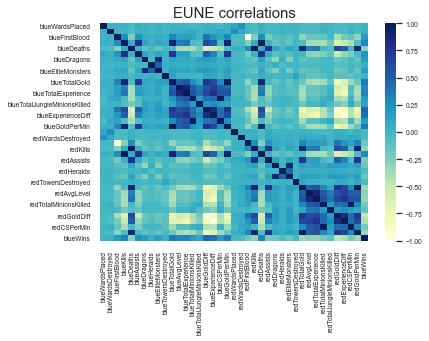

In [37]:
eune_corr_matrix = df_eune_balanced.corr()
# There are too many attributes, so the font needs to be quite small
sns.set(font_scale=0.6)
sns.heatmap(eune_corr_matrix,cmap="YlGnBu")
plt.title("EUNE correlations", fontsize=15)

Since our goal is to find correlations between game data and match result (blueWins), we only look at blueWins column from the matrix. 

In [38]:
# Sorting blueWins column correlations by descending
abs(eune_corr_matrix["blueWins"]).sort_values(ascending=False)

blueWins                        1.000000
blueGoldDiff                    0.463782
redGoldDiff                     0.463782
redExperienceDiff               0.413971
blueExperienceDiff              0.413971
blueGoldPerMin                  0.358372
blueTotalGold                   0.358169
redGoldPerMin                   0.350298
redTotalGold                    0.349742
blueTotalExperience             0.318804
redTotalExperience              0.315929
redDeaths                       0.301064
blueKills                       0.301064
redKills                        0.291282
blueDeaths                      0.291282
redAvgLevel                     0.282660
blueAvgLevel                    0.274980
blueAssists                     0.234136
redAssists                      0.230824
redCSPerMin                     0.194815
redTotalMinionsKilled           0.194633
blueTotalMinionsKilled          0.187326
blueCSPerMin                    0.187322
blueFirstBlood                  0.184695
redFirstBlood   

As expected, blueGoldDiff and redGoldDiff, redExperienceDiff and blueExperienceDiff, redDeaths and blueKills, redKills and blueDeaths all have the same correlation in pairs, because they are either additive or inverse of the other, or the same.

Text(0.5, 1.0, 'EUNE correlations between game data and match result')

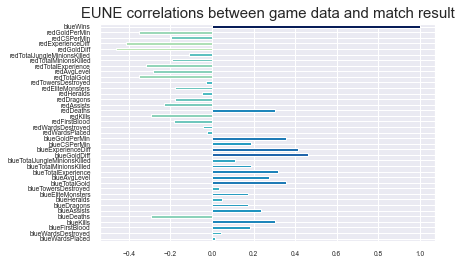

In [39]:
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
colors = [plt.cm.YlGnBu(norm(c)) for c in eune_corr_matrix["blueWins"].values]
eune_corr_matrix["blueWins"].plot.barh(color=colors)
plt.title("EUNE correlations between game data and match result", fontsize=15)

### EUW correlations

We do the exact sames steps for EUW as we have done for EUNE.

Text(0.5, 1.0, 'EUW correlations')

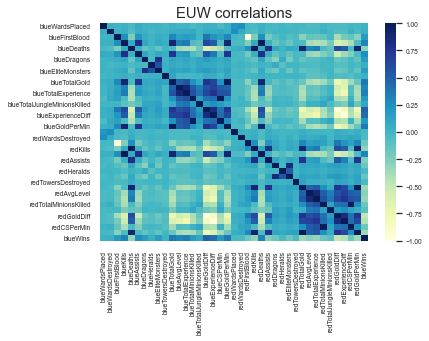

In [40]:
euw_corr_matrix = df_euw_balanced.corr()
sns.heatmap(euw_corr_matrix, cmap="YlGnBu")
plt.title("EUW correlations", fontsize=15)

In [41]:
# Sorting blueWins column correlations by descending
abs(euw_corr_matrix["blueWins"]).sort_values(ascending=False)

blueWins                        1.000000
redGoldDiff                     0.477467
blueGoldDiff                    0.477467
redExperienceDiff               0.423001
blueExperienceDiff              0.423001
blueTotalGold                   0.370142
blueGoldPerMin                  0.370117
redGoldPerMin                   0.358300
redTotalGold                    0.358272
blueTotalExperience             0.333556
redTotalExperience              0.315416
blueKills                       0.308266
redDeaths                       0.308266
redKills                        0.297677
blueDeaths                      0.297677
blueAvgLevel                    0.289797
redAvgLevel                     0.273460
blueAssists                     0.260644
redAssists                      0.251834
blueTotalMinionsKilled          0.192343
blueCSPerMin                    0.192338
blueFirstBlood                  0.181889
redFirstBlood                   0.181735
blueDragons                     0.179581
redTotalMinionsK

As with the EUNE servers, EUW servers also have the same correlation for redGoldDiff and blueGoldDiff, redExperienceDiff and blueExperienceDiff, blueKills and redDeaths, blueDeaths and redKills. On the other hand, in comparison to the EUNE servers, EUW servers team stats differ a bit more. The largest gap is between totalExperience, where blue team has a correlation of ~0.3336 and red team has a correlation of ~0.3154.

Text(0.5, 1.0, 'EUW correlations between game data and match result')

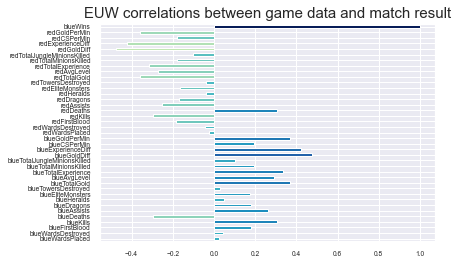

In [42]:
colors = [plt.cm.YlGnBu(norm(c)) for c in euw_corr_matrix["blueWins"].values]
euw_corr_matrix["blueWins"].plot.barh(color=colors)
plt.title("EUW correlations between game data and match result", fontsize=15)

### Summary of correlations

We notice that for both servers in our dataset, gold and experience are the two attributes influencing the match result the most. On the other hand, according to the correlation plots, placing or destroying wards and destroying towers have the least impact on the match result. For players, this might seem quite contradictory, since often we are taught that vision is key and you should play for objectives (towers, dragons, heralds) rather than kills. So how does this make sense? Well, the game consists of early game, mid game and late game. We are analyzing the first ten minutes of the game so this means only the early game. In the early stages of the game, vision plays a much smaller role since most players are simply staying in their own positions and don't move around the playing field a lot. There also isn't many towers going down in the first 10 minutes of the game, since the damage dealt to structures is quite low before players have earned a sufficient amount of gold to buy strong items.

Visually there is almost no difference between both server's correlation plots. This is of course expected, since even though the playstyles of the two servers differ a bit, they are still all playing the same game and the variables leading to victory will be quite similar across all servers.

# Dividing data for models

First of all, let's define the features we will use for training our models. Using all of the columns can lead to overfitting, therefore it is best to remove ones that have a smaller chance of determining the game result. From examining the correlations, we can remove the features that correlate to blueWins the least.\
We will also drop the matchId column since it does not influence the blueWins in any way.

In [102]:
drop = ['matchId','blueWardsPlaced','redWardsPlaced',
        'blueTowersDestroyed','redTowersDestroyed','redHeralds','blueHeralds',
        'blueWins']

Split up the data into training sets, validation and test sets.

In [103]:
features_euw = df_euw_balanced.drop(drop,axis=1)
features_eune = df_eune_balanced.drop(drop,axis=1)

target_euw = df_euw_balanced["blueWins"]
target_eune = df_eune_balanced["blueWins"]

# We divide data into train 80%, test 10% and validation 10%
# EUW
X_train_euw, X_valtest_euw, y_train_euw, y_valtest_euw = train_test_split(features_euw, target_euw,test_size=0.2, random_state=0)
X_val_euw, X_test_euw, y_val_euw, y_test_euw = train_test_split(X_valtest_euw, y_valtest_euw, test_size=0.5, random_state=0)
# EUNE
X_train_eune, X_valtest_eune, y_train_eune, y_valtest_eune = train_test_split(features_eune, target_eune,test_size=0.2,random_state=0)
X_val_eune, X_test_eune, y_val_eune, y_test_eune = train_test_split(X_valtest_eune, y_valtest_eune, test_size=0.5, random_state=0)

In [104]:
X_train_eune

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueEliteMonsters,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redEliteMonsters,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
2535,1,6,0,9,1,1,16101,6.6,16598,203,4096,1057,22.550377,1788.589287,0,0,6,0,0,0,12005,6.2,15541,193,-4096,-1057,21.439521,1333.582659
5930,1,5,3,5,0,0,14751,6.6,16863,187,1285,139,20.768893,1638.299172,0,3,5,3,0,0,13466,7.0,16724,180,-1285,-139,19.991448,1495.582445
10227,0,3,3,2,1,1,13032,6.6,15599,152,-495,154,16.885355,1447.697056,1,3,3,3,0,0,13527,6.4,15445,186,495,-154,20.662343,1502.685549
641,1,3,9,5,0,0,14133,6.2,14940,215,-2702,-2517,23.881282,1569.833312,0,9,3,4,0,0,16835,7.0,17457,201,2702,2517,22.326222,1869.959939
529,0,6,10,5,1,1,16417,6.6,16415,200,674,616,22.215229,1823.537035,1,10,6,14,0,0,15743,6.6,15799,162,-674,-616,17.994335,1748.671714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13472,1,4,3,3,1,1,14971,6.6,16226,197,1262,795,21.883742,1663.053319,0,3,4,3,0,0,13709,6.2,15431,170,-1262,-795,18.884448,1522.864067
3316,0,4,4,3,1,1,14100,6.6,16576,185,-745,321,20.549809,1566.228703,1,4,4,5,0,0,14845,6.6,16255,197,745,-321,21.882770,1648.983340
14489,0,7,12,4,0,0,14658,5.8,14254,174,-2012,-530,19.328573,1628.265631,1,12,7,11,1,1,16670,6.4,14784,136,2012,530,15.107390,1851.766139
2608,1,5,8,6,0,0,14082,6.0,14647,179,-1058,-1722,19.882703,1564.180033,0,8,5,6,1,1,15140,6.6,16369,153,1058,1722,16.994713,1681.699027


In [105]:
y_train_eune

2535     1
5930     1
10227    1
641      0
529      0
        ..
13472    1
3316     1
14489    0
2608     0
7147     1
Name: blueWins, Length: 10388, dtype: int64

# Creating models

In [106]:
# Saving the accuracies of each model for future visualization and comparing
Accuracies_EUW = pd.DataFrame(columns=['model', 'accuracy'])
Accuracies_EUNE = pd.DataFrame(columns=['model', 'accuracy'])

In [107]:
# Functions for accuracy and confusion matrix
def addAccuracy(model_name, model_accuracy, data):
    new_row = pd.DataFrame({'model': [model_name], 'accuracy': model_accuracy})
    data = pd.concat([data, new_row])
    print("The accuracy of", model_name, "is %.4f."% model_accuracy)
    return data
def findConfusionMatrix(data, model_name, model_predictions):
    confusion_matrix_result = confusion_matrix(data, model_predictions, labels=[1,0])
    print(model_name," confusion matrix:\n%s" % confusion_matrix_result)
    return confusion_matrix_result

### AdaBoost Classifier

As the first model, we decided to use AdaBoost Classifier.

In [108]:
# Creating the models
AdaBoostClassifier_model_EUW = AdaBoostClassifier()
AdaBoostClassifier_model_EUNE = AdaBoostClassifier()

# Training
AdaBoostClassifier_model_EUW.fit(X_train_euw, y_train_euw)
AdaBoostClassifier_model_EUNE.fit(X_train_eune, y_train_eune)

# Predicting
y_predicted_AdaBoostClassifier_EUW = AdaBoostClassifier_model_EUW.predict(X_val_euw)
y_predicted_AdaBoostClassifier_EUNE = AdaBoostClassifier_model_EUNE.predict(X_val_eune)

In [109]:
# Accuracy
Accuracy_AdaBoostClassifier_EUW = accuracy_score(y_val_euw, np.rint(y_predicted_AdaBoostClassifier_EUW))
Accuracy_AdaBoostClassifier_EUNE = accuracy_score(y_val_euw, np.rint(y_predicted_AdaBoostClassifier_EUNE))

Accuracies_EUW = addAccuracy("ABC_EUW", Accuracy_AdaBoostClassifier_EUW, Accuracies_EUW)
Accuracies_EUNE = addAccuracy("ABC_EUNE", Accuracy_AdaBoostClassifier_EUNE, Accuracies_EUNE)

The accuracy of ABC_EUW is 0.7082.
The accuracy of ABC_EUNE is 0.7013.


In [110]:
# Confusion matrix
cm_AdaBoostClassifier_EUW = findConfusionMatrix(y_val_euw, "ABC_EUW", np.rint(y_predicted_AdaBoostClassifier_EUW))
cm_AdaBoostClassifier_EUNE = findConfusionMatrix(y_val_eune, "ABC_EUNE", np.rint(y_predicted_AdaBoostClassifier_EUNE))

ABC_EUW  confusion matrix:
[[455 175]
 [204 465]]
ABC_EUNE  confusion matrix:
[[454 176]
 [212 457]]


To improve the accuracy of the model, we decided to use hyperparameter tuning with RandomizedSearchCV.

In [111]:
# Find out which parametres can be changed
AdaBoostClassifier().get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [112]:
parameters = {'algorithm': ('SAMME','SAMME.R'),
              'learning_rate': np.arange(0,100,0.5),
              'n_estimators':np.arange(1,100,1),
             }

#grid_AdaBoostClassifier_EUNE = RandomizedSearchCV(AdaBoostClassifier(random_state = 9), param_distributions=parameters)
#grid_AdaBoostClassifier_EUW = RandomizedSearchCV(AdaBoostClassifier(random_state = 9), param_distributions=parameters)

grid_AdaBoostClassifier_EUW = AdaBoostClassifier(n_estimators = 36,learning_rate= 1, algorithm= 'SAMME')
grid_AdaBoostClassifier_EUNE = AdaBoostClassifier(n_estimators = 50,learning_rate= 1.5, algorithm= 'SAMME.R')

# Training
grid_AdaBoostClassifier_EUW.fit(X_train_eune,y_train_eune)
#print("EUW AdaBoostClassifier best params: ",grid_AdaBoostClassifier_EUNE.best_params_)
grid_AdaBoostClassifier_EUNE.fit(X_train_euw,y_train_euw)
#print("EUNE AdaBoostClassifier best params: ",grid_AdaBoostClassifier_EUW.best_params_)

# Predicting
y_predicted_grid_AdaBoostClassifier_EUW = grid_AdaBoostClassifier_EUW.predict(X_val_euw)
y_predicted_grid_AdaBoostClassifier_EUNE = grid_AdaBoostClassifier_EUNE.predict(X_val_eune)

In [113]:
# Accuracy
Accuracy_grid_AdaBoostClassifier_EUW = accuracy_score(y_val_euw, y_predicted_grid_AdaBoostClassifier_EUW)
Accuracy_grid_AdaBoostClassifier_EUNE = accuracy_score(y_val_eune, y_predicted_grid_AdaBoostClassifier_EUNE)

Accuracies_EUW = addAccuracy("gABC_EUW", Accuracy_grid_AdaBoostClassifier_EUW, Accuracies_EUW)
Accuracies_EUNE = addAccuracy("gABC_EUNE", Accuracy_grid_AdaBoostClassifier_EUNE, Accuracies_EUNE)

The accuracy of gABC_EUW is 0.7082.
The accuracy of gABC_EUNE is 0.6952.


In [114]:
cm_grid_AdaBoostClassifier_EUW = findConfusionMatrix(y_val_euw, "gABC_EUW", y_predicted_grid_AdaBoostClassifier_EUW)
cm_grid_AdaBoostClassifier_EUNE = findConfusionMatrix(y_val_eune, "gABC_EUNE", y_predicted_grid_AdaBoostClassifier_EUNE)

gABC_EUW  confusion matrix:
[[451 179]
 [200 469]]
gABC_EUNE  confusion matrix:
[[460 170]
 [226 443]]


### K-nearest neighbors

The second model was chosen to be KNeighborsClassifier, which uses the k-nearest neighbors method to classify results.

In [115]:
# Creating the models
KNeighborsClassifier_model_EUW = KNeighborsClassifier()
KNeighborsClassifier_model_EUNE = KNeighborsClassifier()

# Training
KNeighborsClassifier_model_EUW.fit(X_train_euw, y_train_euw)
KNeighborsClassifier_model_EUNE.fit(X_train_eune, y_train_eune)

# Predicting
y_predicted_KNeighborsClassifier_EUW = KNeighborsClassifier_model_EUW.predict(X_val_euw)
y_predicted_KNeighborsClassifier_EUNE = KNeighborsClassifier_model_EUNE.predict(X_val_eune)

In [116]:
# Accuracy
Accuracy_KNeighborsClassifier_EUW = accuracy_score(y_val_euw, y_predicted_KNeighborsClassifier_EUW)
Accuracy_KNeighborsClassifier_EUNE = accuracy_score(y_val_eune, y_predicted_KNeighborsClassifier_EUNE)

Accuracies_EUW = addAccuracy("KNN_EUW", Accuracy_KNeighborsClassifier_EUW, Accuracies_EUW)
Accuracies_EUNE = addAccuracy("KNN_EUNE", Accuracy_KNeighborsClassifier_EUNE, Accuracies_EUNE)

The accuracy of KNN_EUW is 0.6567.
The accuracy of KNN_EUNE is 0.6574.


In [117]:
# Confusion matrix
cm_KNeighborsClassifier_EUW = findConfusionMatrix(y_val_euw, "KNN_EUW", y_predicted_KNeighborsClassifier_EUW)
cm_KNeighborsClassifier_EUNE = findConfusionMatrix(y_val_eune, "KNN_EUNE", y_predicted_KNeighborsClassifier_EUNE)

KNN_EUW  confusion matrix:
[[418 212]
 [234 435]]
KNN_EUNE  confusion matrix:
[[411 219]
 [226 443]]


To improve the accuracy of the model, we tried to use different parametres. We used hyperparameter tuning with RandomizedSearchCV.

In [118]:
# Find out which parametres can be changed
KNeighborsClassifier().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [119]:
parameters = {'weights': ('uniform','distance'),
             'algorithm':('auto','ball_tree', 'kd_tree', 'brute'),
              'n_neighbors': np.arange(1,len(X_train_eune.columns),1),
              'leaf_size':np.arange(1,100,1),
              'p': np.arange(1,2,1),
             }

#grid_KNeighborsClassifier_EUNE = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=parameters)
#grid_KNeighborsClassifier_EUW = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=parameters)

grid_KNeighborsClassifier_EUNE = KNeighborsClassifier(weights = 'uniform', n_neighbors= 20, leaf_size= 69, p= 1)
grid_KNeighborsClassifier_EUW = KNeighborsClassifier(weights = 'uniform', n_neighbors= 13, leaf_size= 96, p= 1)

# Training
grid_KNeighborsClassifier_EUNE.fit(X_train_eune, y_train_eune)
#print("EUNE KNeighborsClassifier best params: ",grid_KNeighborsClassifier_EUNE.best_params_)
grid_KNeighborsClassifier_EUW.fit(X_train_euw, y_train_euw)
#print("EUW KNeighborsClassifier best params: ",grid_KNeighborsClassifier_EUW.best_params_)

# Predicting
y_predicted_grid_KNeighborsClassifier_EUW = grid_KNeighborsClassifier_EUW.predict(X_val_euw)
y_predicted_grid_KNeighborsClassifier_EUNE = grid_KNeighborsClassifier_EUNE.predict(X_val_eune)

In [120]:
# Accuracy
Accuracy_grid_KNeighborsClassifier_EUW = accuracy_score(y_val_euw, y_predicted_grid_KNeighborsClassifier_EUW)
Accuracy_grid_KNeighborsClassifier_EUNE = accuracy_score(y_val_eune, y_predicted_grid_KNeighborsClassifier_EUNE)

Accuracies_EUW = addAccuracy("gKNN_EUW", Accuracy_grid_KNeighborsClassifier_EUW, Accuracies_EUW)
Accuracies_EUNE = addAccuracy("gKNN_EUNE", Accuracy_grid_KNeighborsClassifier_EUNE, Accuracies_EUNE)

The accuracy of gKNN_EUW is 0.6782.
The accuracy of gKNN_EUNE is 0.6790.


In [121]:
cm_grid_KNeighborsClassifier_EUW = findConfusionMatrix(y_val_euw, "gKNN_EUW", y_predicted_grid_KNeighborsClassifier_EUW)
cm_grid_KNeighborsClassifier_EUNE = findConfusionMatrix(y_val_eune, "gKNN_EUNE", y_predicted_grid_KNeighborsClassifier_EUNE)

gKNN_EUW  confusion matrix:
[[437 193]
 [225 444]]
gKNN_EUNE  confusion matrix:
[[414 216]
 [201 468]]


### Decision Tree classifier

Third model is DecisionTreeClassifier with default parameters.

In [122]:
# Creating the models
DecisionTreeClassifier_model_EUW = DecisionTreeClassifier(random_state=0)
DecisionTreeClassifier_model_EUNE = DecisionTreeClassifier(random_state=0)

# Training
DecisionTreeClassifier_model_EUW.fit(X_train_euw, y_train_euw)
DecisionTreeClassifier_model_EUNE.fit(X_train_eune, y_train_eune)

# Predicting
y_predicted_DecisionTreeClassifier_EUW = DecisionTreeClassifier_model_EUW.predict(X_val_euw)
y_predicted_DecisionTreeClassifier_EUNE = DecisionTreeClassifier_model_EUNE.predict(X_val_eune)

In [123]:
# Accuracy
Accuracy_DecisionTreeClassifier_EUW = accuracy_score(y_val_euw, y_predicted_DecisionTreeClassifier_EUW)
Accuracy_DecisionTreeClassifier_EUNE = accuracy_score(y_val_eune, y_predicted_DecisionTreeClassifier_EUNE)

Accuracies_EUW = addAccuracy("DTC_EUW", Accuracy_DecisionTreeClassifier_EUW, Accuracies_EUW)
Accuracies_EUNE = addAccuracy("DTC_EUNE", Accuracy_DecisionTreeClassifier_EUNE, Accuracies_EUNE)

The accuracy of DTC_EUW is 0.6143.
The accuracy of DTC_EUNE is 0.6128.


In [124]:
# Confusion matrix
cm_DecisionTreeClassifier_EUW = findConfusionMatrix(y_val_euw, "DTC_EUW", y_predicted_DecisionTreeClassifier_EUW)
cm_DecisionTreeClassifier_EUNE = findConfusionMatrix(y_val_eune, "DTC_EUNE", y_predicted_DecisionTreeClassifier_EUNE)

DTC_EUW  confusion matrix:
[[376 254]
 [247 422]]
DTC_EUNE  confusion matrix:
[[384 246]
 [257 412]]


To improve the prediction, we use hyperparameter tuning with RandomizedSearchCV.\
Since the RandomizedSearchCV always finds a different combination of parameters as the best one, we decided to just take one of the best parameters that the model had during creating models. We have commented out the parameter tuning code.

In [125]:
# Defining the parameters that we will be tuning
# EUNE and EUW have the same amount of features, so it does not matter which one we use in max_features
parameters = {''
    'criterion': ('gini','entropy'),
             'splitter':('best','random'),
              'max_depth': np.arange(1,100,1),
              'min_samples_split':np.arange(2,100,1),
              'min_samples_leaf': np.arange(2,100,1),
              'min_weight_fraction_leaf': np.arange(0,0.5,0.1),
              'max_features': np.arange(1,len(X_train_eune.columns),1),
             }
# Creating the models
#grid_DecisionTreeClassifier_EUNE = RandomizedSearchCV(DecisionTreeClassifier(random_state=0), param_distributions=parameters, cv=100, verbose=1)
#grid_DecisionTreeClassifier_EUW = RandomizedSearchCV(DecisionTreeClassifier(random_state=0), param_distributions=parameters, cv=100, verbose=1)

grid_DecisionTreeClassifier_EUNE = DecisionTreeClassifier(random_state=0, splitter='random', min_weight_fraction_leaf=0.1,
                                                         min_samples_split=40,min_samples_leaf=74,max_features=23,max_depth=64,
                                                         criterion='entropy')
grid_DecisionTreeClassifier_EUW = DecisionTreeClassifier(random_state=0, splitter='best', min_weight_fraction_leaf=0.2,
                                                         min_samples_split=90,min_samples_leaf=56,max_features=30,max_depth=21,
                                                         criterion='gini')
# Training
grid_DecisionTreeClassifier_EUNE.fit(X_train_eune,y_train_eune)
# print("EUNE DecisionTreeClassifier best params: ",grid_DecisionTreeClassifier_EUNE.best_params_)
grid_DecisionTreeClassifier_EUW.fit(X_train_euw,y_train_euw)
# print("EUW DecisionTreeClassifier best params: ",grid_DecisionTreeClassifier_EUW.best_params_)

# Predicting
y_predicted_grid_DecisionTreeClassifier_EUW = grid_DecisionTreeClassifier_EUW.predict(X_val_euw)
y_predicted_grid_DecisionTreeClassifier_EUNE = grid_DecisionTreeClassifier_EUNE.predict(X_val_eune)

In [126]:
# Accuracy
Accuracy_grid_DecisionTreeClassifier_EUW = accuracy_score(y_val_euw,y_predicted_grid_DecisionTreeClassifier_EUW)
Accuracy_grid_DecisionTreeClassifier_EUNE = accuracy_score(y_val_eune,y_predicted_grid_DecisionTreeClassifier_EUNE)

Accuracies_EUW = addAccuracy("gDTC_EUW", Accuracy_grid_DecisionTreeClassifier_EUW, Accuracies_EUW)
Accuracies_EUNE = addAccuracy("gDTC_EUNE", Accuracy_grid_DecisionTreeClassifier_EUNE, Accuracies_EUNE)

The accuracy of gDTC_EUW is 0.7044.
The accuracy of gDTC_EUNE is 0.6890.


In [127]:
# Confusion matrix
cm_grid_DecisionTreeClassifier_EUW = findConfusionMatrix(y_val_euw, "gDTC_EUW", y_predicted_grid_DecisionTreeClassifier_EUW)
cm_grid_DecisionTreeClassifier_EUNE = findConfusionMatrix(y_val_eune, "gDTC_EUNE", y_predicted_grid_DecisionTreeClassifier_EUNE)

gDTC_EUW  confusion matrix:
[[486 144]
 [240 429]]
gDTC_EUNE  confusion matrix:
[[524 106]
 [298 371]]


### Random Forest classifier

Fourth model is RandomForestClassifier with default parameters.

In [128]:
# Creating the models
RandomForestClassifier_model_EUW = RandomForestClassifier(random_state=0)
RandomForestClassifier_model_EUNE = RandomForestClassifier(random_state=0)

# Training
RandomForestClassifier_model_EUW.fit(X_train_euw, y_train_euw)
RandomForestClassifier_model_EUNE.fit(X_train_eune, y_train_eune)

# Predicting
y_predicted_RandomForestClassifier_EUW = RandomForestClassifier_model_EUW.predict(X_val_euw)
y_predicted_RandomForestClassifier_EUNE = RandomForestClassifier_model_EUNE.predict(X_val_eune)

In [129]:
# Accuracy
Accuracy_RandomForestClassifier_EUW = accuracy_score(y_val_euw, y_predicted_RandomForestClassifier_EUW)
Accuracy_RandomForestClassifier_EUNE = accuracy_score(y_val_eune, y_predicted_RandomForestClassifier_EUNE)

Accuracies_EUW = addAccuracy("RFC_EUW", Accuracy_RandomForestClassifier_EUW, Accuracies_EUW)
Accuracies_EUNE = addAccuracy("RFC_EUNE", Accuracy_RandomForestClassifier_EUNE, Accuracies_EUNE)

The accuracy of RFC_EUW is 0.7105.
The accuracy of RFC_EUNE is 0.6859.


In [130]:
# Confusion matrix
cm_RandomForestClassifier_EUW = findConfusionMatrix(y_val_euw, "RFC_EUW", y_predicted_RandomForestClassifier_EUW)
cm_RandomForestClassifier_EUNE = findConfusionMatrix(y_val_eune, "RFC_EUNE", y_predicted_RandomForestClassifier_EUNE)

RFC_EUW  confusion matrix:
[[442 188]
 [188 481]]
RFC_EUNE  confusion matrix:
[[439 191]
 [217 452]]


To improve the prediction, we use hyperparameter tuning with RandomizedSearchCV.

In [131]:
parameters = {'criterion': ('gini','entropy'),
              'max_depth': np.arange(1,100,1),
              'min_samples_split':np.arange(2,100,1),
              'min_samples_leaf': np.arange(2,100,1),
              'min_weight_fraction_leaf': np.arange(0,0.5,0.1),
              'max_features': np.arange(1,len(X_train_eune.columns),1),
             }
# Creating the models
#grid_RandomForestClassifier_EUNE = RandomizedSearchCV(RandomForestClassifier(random_state=0), param_distributions=parameters, cv=10, verbose=1,error_score='raise')
#grid_RandomForestClassifier_EUW = RandomizedSearchCV(RandomForestClassifier(random_state=0), param_distributions=parameters, cv=10, verbose=1,error_score='raise')


grid_RandomForestClassifier_EUNE = RandomForestClassifier(random_state=0, min_weight_fraction_leaf=0.0,
                                                         min_samples_split=24,min_samples_leaf=75,max_features=20,max_depth=89,
                                                         criterion='gini')
grid_RandomForestClassifier_EUW = RandomForestClassifier(random_state=0, min_weight_fraction_leaf=0.0,
                                                         min_samples_split=81,min_samples_leaf=97,max_features=23,max_depth=98,
                                                         criterion='gini')

# Training
grid_RandomForestClassifier_EUNE.fit(X_train_eune,y_train_eune)
#print("EUNE RandomForestClassifier best params: ",grid_RandomForestClassifier_EUNE.best_params_)
grid_RandomForestClassifier_EUW.fit(X_train_euw,y_train_euw)
#print("EUW RandomForestClassifier best params: ",grid_RandomForestClassifier_EUW.best_params_)

# Predicting
y_predicted_grid_RandomForestClassifier_EUW = grid_RandomForestClassifier_EUW.predict(X_val_euw)
y_predicted_grid_RandomForestClassifier_EUNE = grid_RandomForestClassifier_EUNE.predict(X_val_eune)

In [132]:
# Accuracy
Accuracy_grid_RandomForestClassifier_EUW = accuracy_score(y_val_euw, y_predicted_grid_RandomForestClassifier_EUW)
Accuracy_grid_RandomForestClassifier_EUNE = accuracy_score(y_val_eune, y_predicted_grid_RandomForestClassifier_EUNE)

Accuracies_EUW = addAccuracy("gRFC_EUW", Accuracy_grid_RandomForestClassifier_EUW, Accuracies_EUW)
Accuracies_EUNE = addAccuracy("gRFC_EUNE", Accuracy_grid_RandomForestClassifier_EUNE, Accuracies_EUNE)

The accuracy of gRFC_EUW is 0.7190.
The accuracy of gRFC_EUNE is 0.7052.


In [133]:
# Confusion matrix
cm_grid_RandomForestClassifier_EUW = findConfusionMatrix(y_val_euw, "gRFC_EUW", y_predicted_grid_RandomForestClassifier_EUW)
cm_grid_RandomForestClassifier_EUNE = findConfusionMatrix(y_val_eune, "gRFC_EUNE", y_predicted_grid_RandomForestClassifier_EUNE)

gRFC_EUW  confusion matrix:
[[452 178]
 [187 482]]
gRFC_EUNE  confusion matrix:
[[457 173]
 [210 459]]


### Naive Bayes

Fifth model is Naive Bayes.

In [134]:
# Creating the models
NaiveBayes_EUW = GaussianNB()
NaiveBayes_EUNE = GaussianNB()

# Training
NaiveBayes_EUW.fit(X_train_euw, y_train_euw)
NaiveBayes_EUNE.fit(X_train_eune, y_train_eune)

# Predicting
y_predicted_NaiveBayes_EUW = NaiveBayes_EUW.predict(X_val_euw)
y_predicted_NaiveBayes_EUNE = NaiveBayes_EUNE.predict(X_val_eune)

In [135]:
# Accuracy
Accuracy_NaiveBayes_EUW = accuracy_score(y_val_euw, y_predicted_NaiveBayes_EUW)
Accuracy_NaiveBayes_EUNE = accuracy_score(y_val_eune, y_predicted_NaiveBayes_EUNE)

Accuracies_EUW = addAccuracy("NB_EUW", Accuracy_NaiveBayes_EUW, Accuracies_EUW)
Accuracies_EUNE = addAccuracy("NB_EUNE", Accuracy_NaiveBayes_EUNE, Accuracies_EUNE)

The accuracy of NB_EUW is 0.7067.
The accuracy of NB_EUNE is 0.7075.


In [136]:
# Confusion matrix
cm_NaiveBayes_EUW = findConfusionMatrix(y_val_euw, "NB_EUW", y_predicted_NaiveBayes_EUW)
cm_NaiveBayes_EUNE = findConfusionMatrix(y_val_eune, "NB_EUNE", y_predicted_NaiveBayes_EUNE)

NB_EUW  confusion matrix:
[[438 192]
 [189 480]]
NB_EUNE  confusion matrix:
[[458 172]
 [208 461]]


### Voting Classifier

As the sixth and final model, we decided to use a Voting Classifier model. This combines previous models and uses them to get a majority vote to predict the class labels. By using all of our previous models and using them to vote, we hope to achieve the best accuracy so far.

In [137]:
# Defining the models we will use
modelsEUW = [('NB',NaiveBayes_EUW),('RFC',grid_RandomForestClassifier_EUW),
             ('DTC',grid_DecisionTreeClassifier_EUW)]
modelsEUNE = [('NB',NaiveBayes_EUNE),('RFC',grid_RandomForestClassifier_EUNE),
             ('DTC',grid_DecisionTreeClassifier_EUNE)]

# Creating the models
VC_EUW = VotingClassifier(estimators=modelsEUW,voting='soft')
VC_EUNE = VotingClassifier(estimators=modelsEUNE,voting='soft')

# Training
VC_EUW.fit(X_train_euw, y_train_euw)
VC_EUNE.fit(X_train_eune, y_train_eune)

# Predicting
y_predicted_VC_EUW = VC_EUW.predict(X_val_euw)
y_predicted_VC_EUNE = VC_EUNE.predict(X_val_eune)

In [138]:
# Accuracy
Accuracy_VC_EUW = accuracy_score(y_val_euw, y_predicted_VC_EUW)
Accuracy_VC_EUNE = accuracy_score(y_val_eune, y_predicted_VC_EUNE)

Accuracies_EUW = addAccuracy("VC_EUW", Accuracy_VC_EUW, Accuracies_EUW)
Accuracies_EUNE = addAccuracy("VC_EUNE", Accuracy_VC_EUNE, Accuracies_EUNE)

The accuracy of VC_EUW is 0.7059.
The accuracy of VC_EUNE is 0.7082.


In [139]:
# Confusion matrix
cm_VC_EUW = findConfusionMatrix(y_val_euw, "VC_EUW", y_predicted_VC_EUW)
cm_VC_EUNE = findConfusionMatrix(y_val_eune, "VC_EUNE", y_predicted_VC_EUNE)

VC_EUW  confusion matrix:
[[442 188]
 [194 475]]
VC_EUNE  confusion matrix:
[[465 165]
 [214 455]]


### Summary of creating models

We will choose one model from each server, to test them on the test dataset.

We have noticed, that all of the models have better accuracy with EUW server (with our dataset). This could mean that EUNE server (in our dataset) has more games where it is harder to predict whether the blue team will win or not.  !!

In [140]:
Accuracies_EUNE = Accuracies_EUNE.sort_values("accuracy", ascending=False)
print(Accuracies_EUNE)

       model  accuracy
0    VC_EUNE  0.708237
0    NB_EUNE  0.707467
0  gRFC_EUNE  0.705158
0   ABC_EUNE  0.701309
0  gABC_EUNE   0.69515
0  gDTC_EUNE  0.688992
0   RFC_EUNE  0.685912
0  gKNN_EUNE  0.678984
0   KNN_EUNE  0.657429
0   DTC_EUNE  0.612779


In [141]:
Accuracies_EUW = Accuracies_EUW.sort_values("accuracy", ascending=False)
print(Accuracies_EUW)

      model  accuracy
0  gRFC_EUW  0.719015
0   RFC_EUW  0.710547
0   ABC_EUW  0.708237
0  gABC_EUW  0.708237
0    NB_EUW  0.706697
0    VC_EUW  0.705928
0  gDTC_EUW  0.704388
0  gKNN_EUW  0.678214
0   KNN_EUW  0.656659
0   DTC_EUW  0.614319


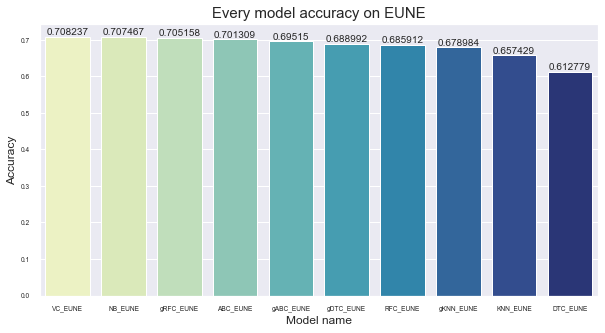

In [142]:
fig = plt.figure(figsize=(10,5))

models_EUNE = Accuracies_EUNE["model"]
accuracies_EUNE = Accuracies_EUNE["accuracy"]

ax = sns.barplot(x=models_EUNE, y=accuracies_EUNE, palette='YlGnBu')
ax.bar_label(ax.containers[0], fontsize=10)

plt.xlabel("Model name", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Every model accuracy on EUNE", fontsize=15)
plt.show()

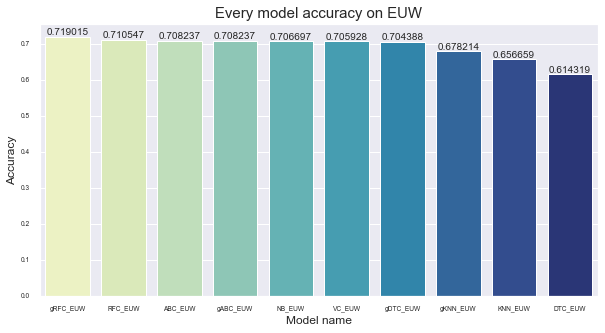

In [143]:
fig = plt.figure(figsize=(10,5))

models_EUW = Accuracies_EUW["model"]
accuracies_EUW = Accuracies_EUW["accuracy"]

ax = sns.barplot(x=models_EUW, y=accuracies_EUW, palette='YlGnBu')
ax.bar_label(ax.containers[0], fontsize=10)

plt.xlabel("Model name", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Every model accuracy on EUW", fontsize=15)
plt.show()

In [144]:
best_accuracy_eune = Accuracies_EUNE.values[0]
best_accuracy_euw = Accuracies_EUW.values[0]

print("Model with the best accuracy on EUNE: ", best_accuracy_eune)
print("Model with the best accuracy on EUW: ", best_accuracy_euw)

Model with the best accuracy on EUNE:  ['VC_EUNE' 0.7082371054657429]
Model with the best accuracy on EUW:  ['gRFC_EUW' 0.7190146266358738]


# Testing the models on the test set

We will be using Voting Classifier for EUNE and RandomForestClassifier (with parameter tuning) for EUW. We chose those models, because they had the best accuracy on validation data during testing.\
First we find out the accuracy of our models on the test data.

In [145]:
# EUNE
best_model_eune_accuracy = accuracy_score(y_test_eune, VC_EUNE.predict(X_test_eune))
# EUW
best_model_euw_accuracy = accuracy_score(y_test_euw, grid_RandomForestClassifier_EUW.predict(X_test_euw))

In [146]:
print("EUNE best model accuracy: ", best_model_eune_accuracy)
print("EUW best model accuracy: ", best_model_euw_accuracy)

EUNE best model accuracy:  0.7059276366435719
EUW best model accuracy:  0.7205542725173211


As we can see, EUNE accuracy has lowered on the test data compared to the validation data.
On the other hand, EUW accuracy is even better on the test data than validation data. 

Now we find the AUC scores of the best performing models and display the ROC curves for both servers.

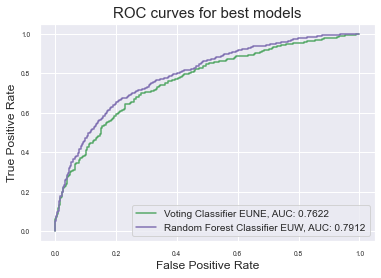

In [147]:
y_predicted_best_EUNE = VC_EUNE.predict_proba(X_test_eune)[::,1]
fpr_EUNE, tpr_EUNE, thresholds_EUNE = roc_curve(y_test_eune, y_predicted_best_EUNE)
AUC_EUNE = roc_auc_score(y_test_eune, y_predicted_best_EUNE)

plt.plot(fpr_EUNE, tpr_EUNE, label="Voting Classifier EUNE, AUC: "+str(AUC_EUNE.round(4)), color="g")

y_predicted_best_EUW = grid_RandomForestClassifier_EUW.predict_proba(X_test_euw)[::,1]
fpr_EUW, tpr_EUW, thresholds_EUW = roc_curve(y_test_euw, y_predicted_best_EUW)
AUC_EUW = roc_auc_score(y_test_euw, y_predicted_best_EUW)

plt.plot(fpr_EUW, tpr_EUW,  label="Random Forest Classifier EUW, AUC: "+str(AUC_EUW.round(4)), color='m')
plt.legend(fontsize=10)
plt.title("ROC curves for best models", fontsize=15)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.show()

Both of the AUC scores are bigger than 0.5. This means that our models predict the game winner better than a random guess.

# Summary of building a model

On both servers the worst performing models were Decision Tree Classifier and K-nearest neighbors. 
!!
worst, best etc, why, how

# Comparing EUNE and EUW servers

Our goal with this is to find out which server is better/stronger based on our dataset. For that we will be comparing different attributes. \
We will not be comparing first blood and blue wins because number of first bloods is the same as number of games (this can be useful, if comparing teams, not servers), number of blue wins is the same for both servers (data is balanced). 

In [148]:
df_eune_balanced.describe()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redEliteMonsters,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
count,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000
mean,15.185815,1.985831,0.509703,5.692515,5.609657,5.717465,0.231326,0.062914,0.294240,0.005621,15044.353766,6.424411,15820.169182,184.321500,49.092946,19.948791,-13.392269,20.473970,1671.101660,15.185584,1.843909,0.489912,5.609657,5.692515,5.594409,0.246650,0.051902,0.298552,0.003234,15024.404975,6.428415,15833.561451,184.698598,49.980671,-19.948791,13.392269,20.515932,1668.894867,0.500000
std,7.703670,1.878386,0.499925,2.762269,2.717027,3.686067,0.421697,0.242817,0.481999,0.091448,1399.770990,0.277197,986.406412,19.642576,8.695388,2128.127924,1514.758917,2.180867,155.308519,7.685615,1.793983,0.499917,2.717027,2.762269,3.633528,0.431078,0.221838,0.487622,0.056781,1388.543505,0.277948,989.451356,19.654898,8.730237,2128.127924,1514.758917,2.182203,154.088463,0.500019
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4721.000000,2.200000,2800.000000,24.000000,0.000000,-8473.000000,-9779.000000,4.239596,833.963875,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5926.000000,2.800000,4065.000000,32.000000,0.000000,-12346.000000,-7256.000000,5.652795,1046.826927,0.000000
25%,11.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14070.250000,6.200000,15195.250000,172.000000,44.000000,-1399.750000,-997.000000,19.104318,1562.910927,11.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14033.000000,6.200000,15205.000000,172.000000,44.000000,-1427.750000,-977.000000,19.104752,1558.787782,0.000000
50%,13.000000,2.000000,1.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,14945.000000,6.400000,15842.000000,185.000000,48.000000,30.000000,-3.000000,20.548706,1660.098810,13.000000,2.000000,0.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,14921.000000,6.400000,15853.000000,185.000000,50.000000,-30.000000,3.000000,20.551807,1657.338889,0.500000
75%,15.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,15909.750000,6.600000,16477.000000,198.000000,56.000000,1427.750000,977.000000,21.992343,1767.144589,15.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,15895.750000,6.600000,16482.000000,198.000000,56.000000,1399.750000,997.000000,21.994379,1765.632919,1.000000
max,50.000000,25.000000,1.000000,20.000000,23.000000,32.000000,1.000000,1.000000,2.000000,6.000000,25217.000000,7.400000,19082.000000,250.000000,84.000000,12346.000000,7256.000000,27.766209,2801.115988,50.000000,24.000000,1.000000,23.000000,20.000000,30.000000,1.000000,1.000000,2.000000,1.000000,21854.000000,7.400000,19218.000000,247.000000,84.000000,8473.000000,9779.000000,27.437636,2427.305240,1.000000


In [149]:
df_euw_balanced.describe()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueEliteMonsters,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redEliteMonsters,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueWins
count,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.00000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000,12986.000000
mean,15.276298,2.096489,0.498614,5.688973,5.651240,5.906284,0.202988,0.101263,0.304251,0.008548,15157.354074,6.421438,15810.835900,187.742569,49.486139,8.135531,-10.937163,20.853922,1683.635954,15.563992,1.960804,0.501155,5.651240,5.688973,5.943170,0.244032,0.080779,0.324811,0.005236,15149.218543,6.42361,15821.773063,188.164485,49.992684,-8.135531,10.937163,20.900703,1682.726447,0.500000
std,7.449993,1.899154,0.500017,2.846622,2.815949,3.786271,0.402239,0.301688,0.494319,0.092894,1432.495540,0.282422,1001.780278,19.655474,8.984786,2181.976944,1525.285752,2.183499,159.137590,7.690406,1.814863,0.500018,2.815949,2.846622,3.868896,0.429528,0.272506,0.505186,0.083088,1427.955115,0.27761,986.153431,19.574296,9.107624,2181.976944,1525.285752,2.173785,158.575402,0.500019
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9322.000000,3.800000,6701.000000,50.000000,0.000000,-12288.000000,-9405.000000,5.554146,973.522798,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10722.000000,4.40000,9618.000000,96.000000,0.000000,-10075.000000,-7154.000000,10.662500,1190.870217,0.000000
25%,11.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14156.000000,6.200000,15186.000000,175.000000,44.000000,-1400.000000,-987.000000,19.439090,1572.423445,12.000000,1.000000,0.000000,4.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,14133.000000,6.20000,15205.000000,175.000000,44.000000,-1425.000000,-964.000000,19.440214,1569.841872,0.000000
50%,13.000000,2.000000,0.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,15066.500000,6.400000,15839.000000,189.000000,48.000000,7.000000,-1.500000,20.992167,1673.610578,13.000000,2.000000,1.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,15043.000000,6.40000,15846.000000,189.000000,49.000000,-7.000000,1.500000,20.992264,1671.070001,0.500000
75%,16.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,16044.000000,6.600000,16481.000000,201.000000,56.000000,1425.000000,964.000000,22.327173,1782.132582,16.000000,3.000000,1.000000,7.000000,7.000000,8.000000,0.000000,0.000000,1.000000,0.000000,16041.750000,6.60000,16474.000000,201.000000,56.000000,1400.000000,987.000000,22.329033,1781.878789,1.000000
max,50.000000,27.000000,1.000000,20.000000,21.000000,31.000000,1.000000,1.000000,2.000000,2.000000,22334.000000,7.400000,19501.000000,256.000000,88.000000,10075.000000,7154.000000,28.437809,2480.949101,50.000000,25.000000,1.000000,21.000000,20.000000,34.000000,1.000000,1.000000,2.000000,5.000000,23235.000000,7.40000,19906.000000,266.000000,84.000000,12288.000000,9405.000000,28.769839,2580.772955,1.000000


### Comparing gold

In LoL having more gold is better because gold is used to make the player and therefore the team stronger. Gold can be aquired from almost everything in the game. Every player gets a passive income. Other gold sources are minions, monsters, kills, assists, towers, wards. To sum it up, any kind of destruction of the jungle or enemy team gives gold to players. Because of that it is the most logical way to compare servers, since gaining gold depends on being good at the game. We cannot assign any weights for gold incomes because the amount of gold gained depends on the game data that we do not have.

Text(0.5, 0.98, 'EUNE total gold per team')

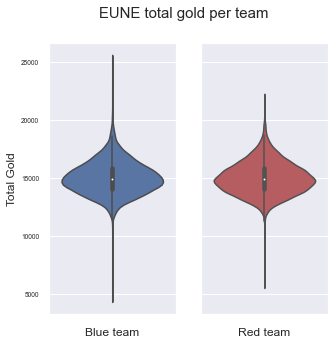

In [150]:
fig, axes = plt.subplots(1,2,figsize=(5,5), sharey=True)

sns.violinplot(ax=axes[0], y="blueTotalGold", data=df_eune_balanced, color='b')
sns.violinplot(ax=axes[1], y="redTotalGold", data=df_eune_balanced, color='r')

axes[0].set_ylabel("Total Gold", fontsize=12)
axes[1].set_ylabel("")

axes[0].set_xlabel("Blue team", fontsize=12)
axes[1].set_xlabel("Red team", fontsize=12)

fig.suptitle("EUNE total gold per team", fontsize=15)

In EUNE both teams have almost same total gold mean. Blue team has much wider scale of total gold distribution than red team. WHY !!


Text(0.5, 0.98, 'EUW total gold per team')

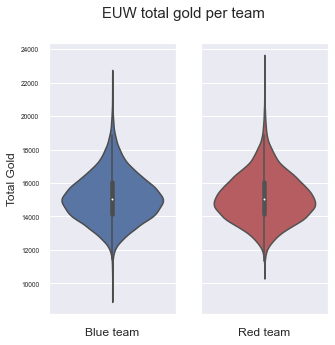

In [151]:
fig, axes = plt.subplots(1,2,figsize=(5,5), sharey=True)

sns.violinplot(ax=axes[0], y="blueTotalGold", data=df_euw_balanced, color='b')
sns.violinplot(ax=axes[1], y="redTotalGold", data=df_euw_balanced, color='r')

axes[0].set_ylabel("Total Gold", fontsize=12)
axes[1].set_ylabel("")

axes[0].set_xlabel("Blue team", fontsize=12)
axes[1].set_xlabel("Red team", fontsize=12)

fig.suptitle("EUW total gold per team", fontsize=15)

something about euw total gold stats !!

In [152]:
print("EUNE blue team total gold mean:", df_eune_balanced["blueTotalGold"].mean())
print("EUNE red team total gold mean:", df_eune_balanced["redTotalGold"].mean())

print("EUW blue team total gold mean:", df_euw_balanced["blueTotalGold"].mean())
print("EUW red team total gold mean:", df_euw_balanced["redTotalGold"].mean())

EUNE blue team total gold mean: 15044.353765593716
EUNE red team total gold mean: 15024.404974588018
EUW blue team total gold mean: 15157.354073617742
EUW red team total gold mean: 15149.218543046358


When comparing the mean total gold of both servers there is no significant difference (only ~100 gold). This means we cannot say which server is better (based on our dataset) in terms of gaing gold.\
Also it is interesting to point that for both servers red team minimum total gold is much higher than blue team minimum total gold. This can be due to the character selection. Red side can pick after the blue team, which means that red team can counterpick characters that dominate the enemy team picked characters. 

### Comparing assists to kills ratio

We can compare servers based on how well the teammembers support each other in getting kills. For that we look at assists and kills ratio in a team.
!!

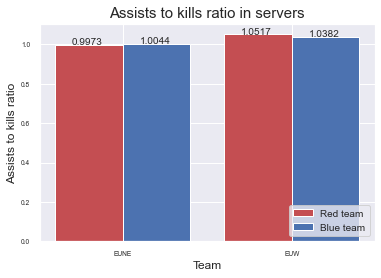

In [153]:
X = ['EUNE','EUW']
assists_to_kills_ratio_red = [df_eune_balanced["redAssists"].sum() /  df_eune_balanced["redKills"].sum(),
                   df_euw_balanced["redAssists"].sum() /  df_euw_balanced["redKills"].sum()]
assists_to_kills_ratio_blue = [df_eune_balanced["blueAssists"].sum() /  df_eune_balanced["blueKills"].sum(),
                   df_euw_balanced["blueAssists"].sum() /  df_euw_balanced["blueKills"].sum()]
X_axis = np.arange(len(X))

plt.bar(X_axis-0.2, assists_to_kills_ratio_red, 0.4, label = 'Red team', color='r')
plt.bar(X_axis+0.2, assists_to_kills_ratio_blue, 0.4, label = 'Blue team', color='b')

plt.annotate(text=assists_to_kills_ratio_red[0].round(4), xy=(-0.3,assists_to_kills_ratio_red[0].round(4)), fontsize=10)
plt.annotate(text=assists_to_kills_ratio_red[1].round(4), xy=(0.7,assists_to_kills_ratio_red[1].round(4)), fontsize=10)
plt.annotate(text=assists_to_kills_ratio_blue[0].round(4), xy=(0.1,assists_to_kills_ratio_blue[0].round(4)), fontsize=10)
plt.annotate(text=assists_to_kills_ratio_blue[1].round(4), xy=(1.1,assists_to_kills_ratio_blue[1].round(4)), fontsize=10)

plt.xticks(X_axis, X)
plt.xlabel("Team", fontsize=12)
plt.ylabel("Assists to kills ratio", fontsize=12)
plt.title("Assists to kills ratio in servers", fontsize=15)
plt.legend(fontsize=10, loc=4)
plt.show()

In [154]:
print("EUNE red team assists to kills ratio: ", assists_to_kills_ratio_red[0])
print("EUW red team assists to kills ratio: ", assists_to_kills_ratio_red[1])

print("EUNE blue team assists to kills ratio: ", assists_to_kills_ratio_blue[0])
print("EUW blue team assists to kills ratio: ", assists_to_kills_ratio_blue[1])

EUNE red team assists to kills ratio:  0.997281974549398
EUW red team assists to kills ratio:  1.0516576505375612
EUNE blue team assists to kills ratio:  1.0043829390040988
EUW blue team assists to kills ratio:  1.0381986274483264


It appears that in our dataset EUW server has higher kill participation than EUNE server on both teams. We think it means that based on our dataset EUW server may be better at teamwork. !!

### Comparing experience

We can compare servers based on how much players participate in the game by looking at the total experience. Experience determines the level of a character. The higher the level, the more abilities the character has and the stronger the teammember is. 

Text(0.5, 0.98, 'EUNE total experience per team')

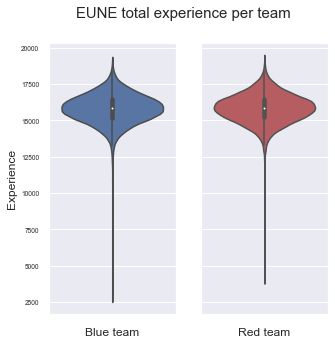

In [155]:
fig, axes = plt.subplots(1,2,figsize=(5,5), sharey=True)

sns.violinplot(ax=axes[0], y="blueTotalExperience", data=df_eune_balanced, color='b')
sns.violinplot(ax=axes[1], y="redTotalExperience", data=df_eune_balanced, color='r')

axes[0].set_ylabel("Experience", fontsize=12)
axes[1].set_ylabel("")

axes[0].set_xlabel("Blue team", fontsize=12)
axes[1].set_xlabel("Red team", fontsize=12)

fig.suptitle("EUNE total experience per team", fontsize=15)

Text(0.5, 0.98, 'EUW total experience per team')

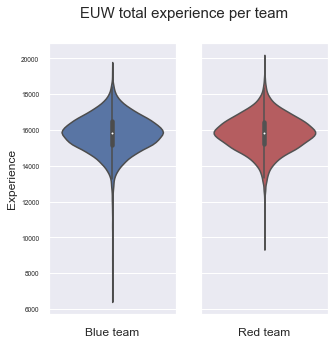

In [156]:
fig, axes = plt.subplots(1,2,figsize=(5,5), sharey=True)

sns.violinplot(ax=axes[0], y="blueTotalExperience", data=df_euw_balanced, color='b')
sns.violinplot(ax=axes[1], y="redTotalExperience", data=df_euw_balanced, color='r')

axes[0].set_ylabel("Experience", fontsize=12)
axes[1].set_ylabel("")

axes[0].set_xlabel("Blue team", fontsize=12)
axes[1].set_xlabel("Red team", fontsize=12)

fig.suptitle("EUW total experience per team", fontsize=15)

In [157]:
print("EUNE blue team total experience mean:", df_eune_balanced["blueTotalExperience"].mean())
print("EUNE red team total experience mean:", df_eune_balanced["redTotalExperience"].mean())

print("EUW blue team total experience mean:", df_euw_balanced["blueTotalExperience"].mean())
print("EUW red team total experience mean:", df_euw_balanced["redTotalExperience"].mean())

EUNE blue team total experience mean: 15820.169182196212
EUNE red team total experience mean: 15833.561450793162
EUW blue team total experience mean: 15810.835900200216
EUW red team total experience mean: 15821.773063298937


It appears that in both servers the average experience of red and blue teams are about 16000. The interesting part is that the blue teams lowest result is much lower than the opposing teams lowest experience. The same applies to the best result. This is the case for both server.

This might be because !!

### Comparing vision

The better the players, the more they pay attention to the map awarness. Map awarness means having vision on the map. Vision is gained by placing wards. \
We know that wards are not always useful because they can be placed anywhere on the map. But we are looking at Diamond I players that usually place wards that benefit them. There is no point in wasting wards because players aquire wards in certain time intervals or by buying them for gold.\
We will look at wardsPlaced.

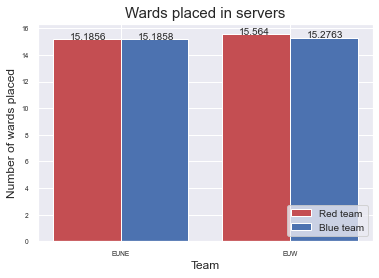

In [158]:
X = ['EUNE','EUW']
wards_placed_red = [df_eune_balanced["redWardsPlaced"].mean(), df_euw_balanced["redWardsPlaced"].mean()]
wards_placed_blue = [df_eune_balanced["blueWardsPlaced"].mean(), df_euw_balanced["blueWardsPlaced"].mean()]
X_axis = np.arange(len(X))

plt.bar(X_axis-0.2, wards_placed_red, 0.4, label = 'Red team', color='r')
plt.bar(X_axis+0.2, wards_placed_blue, 0.4, label = 'Blue team', color='b')

plt.annotate(text=round(wards_placed_red[0],4), xy=(-0.3,round(wards_placed_red[0],4)), fontsize=10)
plt.annotate(text=round(wards_placed_red[1],4), xy=(0.7,round(wards_placed_red[1],4)), fontsize=10)
plt.annotate(text=round(wards_placed_blue[0],4), xy=(0.1,round(wards_placed_blue[0],4)), fontsize=10)
plt.annotate(text=round(wards_placed_blue[1],4), xy=(1.1,round(wards_placed_blue[1],4)), fontsize=10)

plt.xticks(X_axis, X)
plt.xlabel("Team", fontsize=12)
plt.ylabel("Number of wards placed", fontsize=12)
plt.title("Wards placed in servers", fontsize=15)
plt.legend(fontsize=10, loc=4)
plt.show()

conclusion on wards !!

### Comparing KDA

KDA means (kills+assists)/deaths. Higher KDA means better players. Having good KDA may not mean that you win the game, it means that a player dominates in killing. Usually KDA is something that you measure for one player, not a team. But we could look at the servers as playerbases and find their KDA-s. 

### Comparing minions killed

We think that one of the best indicators of player skill level is how many minions they have killed. !!

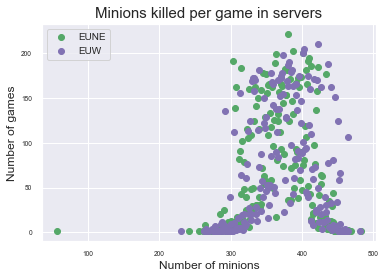

In [159]:
minions_eune =  pd.DataFrame(df_eune_balanced["blueTotalMinionsKilled"] + df_eune_balanced["redTotalMinionsKilled"], columns=["minionsKilled"])
minions_euw = pd.DataFrame(df_euw_balanced["blueTotalMinionsKilled"] + df_euw_balanced["redTotalMinionsKilled"], columns=["minionsKilled"])

plt.scatter(minions_eune["minionsKilled"].unique(), minions_eune["minionsKilled"].value_counts(), color='g', label="EUNE")
plt.scatter(minions_euw["minionsKilled"].unique(), minions_euw["minionsKilled"].value_counts(), color='m', label="EUW")

plt.legend(loc=2, fontsize=10)
plt.title("Minions killed per game in servers", fontsize=15)
plt.xlabel("Number of minions", fontsize=12)
plt.ylabel("Number of games", fontsize=12)
plt.show()

In [160]:
print("EUNE total minions mean: ", minions_eune["minionsKilled"].mean())
print("EUW total minions mean: ", minions_euw["minionsKilled"].mean())


EUNE total minions mean:  369.0200985676883
EUW total minions mean:  375.9070537501925


what does it mean !!

# Summary of comparing servers

Based on our data, EUW had better numbers than EUNE in every comparison but not to a significantly better. !!

# Project summary

Our first goal was to develop a model for predicting the winning team. 

We are pleased with the results of the two models that we chose for each server. The best model for EUW was Random Forest Classifier with parameter tuning. The best model for EUNE was Voting Classifier which combined three models and used majority voting. 

Our second goal was to compare EUNE and EUW servers and get some insight on whether the servers have similarities or not. In addition find out whether one server is better than the other (based on our dataset).

... !! how did we do

### Future porjects

We think that for a future project it would make sense to look at data from different stages of the game and compare the servers based on that information. \
As for predicting the winning team we think that there is also a chance to improve using data from later in the game. If anyone is planning to do something similar, we would reccommend to collect additional data about damage, ward types and each players performance (KDA).